In [1]:
import qiskit
import qiskit_nature
import qiskit_aer

print(f"Qiskit version: {qiskit.__version__}")
print(f"Qiskit Nature version: {qiskit_nature.__version__}")
print(f"Qiskit Aer version: {qiskit_aer.__version__}")


Qiskit version: 1.4.3
Qiskit Nature version: 0.7.2
Qiskit Aer version: 0.17.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit

from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo as Molecule
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit_aer import AerSimulator, Aer
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Estimator


import pickle
import json
from datetime import datetime
import os
from joblib import Parallel, delayed
import time
import pandas as pd
from scipy import stats


qiskit_nature.settings.use_pauli_sum_op = False


https://cccbdb.nist.gov/geom3x.asp?method=1&basis=20

In [3]:
def create_nh3_driver(bond_length=1.0325, bond_angle=107.8, basis='sto3g'):
    """
    Create a parametric NH3 molecule driver with correct C3v geometry.

    Parameters:
    - bond_length: N-H bond length in Angstrom (default: 1.0325)
    - bond_angle: H-N-H bond angle in degrees (default: 107.8)
    - basis: basis set (default: 'sto3g')
    """
    angle_rad = np.deg2rad(bond_angle)
    
    # Height of N above the H triangle plane:
    # From geometry, this can be estimated as:
    h_plane_z = -bond_length * np.cos(angle_rad / 2)
    r_xy = bond_length * np.sin(angle_rad / 2)

    # N at origin (0, 0, 0)
    # Place three H atoms symmetrically in the xy-plane
    h_positions = []
    for i in range(3):
        theta = 2 * np.pi * i / 3  # 120° separation
        x = r_xy * np.cos(theta)
        y = r_xy * np.sin(theta)
        z = h_plane_z
        h_positions.append((x, y, z))
    
    # Build atom string
    atom_string = f"N 0.0 0.0 0.0; "
    atom_string += "; ".join([f"H {x:.6f} {y:.6f} {z:.6f}" for (x, y, z) in h_positions])

    driver = PySCFDriver(
        atom=atom_string,
        basis=basis,
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    return driver

def get_qubit_op(bond_length=1.0325):
    """
    Get the qubit operator for NH3 molecule at given bond length
    
    Parameters:
    bond_length: N-H bond length in Angstrom (default: 1.0325)
    
    Returns:
    tuple: (qubit_op, num_particles, num_spatial_orbitals, problem, mapper)
    """
    # Create driver with given bond length
    driver = create_nh3_driver(bond_length=bond_length)
    problem = FreezeCoreTransformer(freeze_core=True).transform(driver.run())
    
    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals
    
    mapper = ParityMapper(num_particles=problem.num_particles,)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    
    return (qubit_op, num_particles, num_spatial_orbitals, problem, mapper)

In [4]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

In [5]:
import time

def compute_single_distance(dist, optimizer_type='SLSQP', ansatz='UCCSD', maxiter=10):
    """
    Compute VQE and exact energies for a single bond distance
    
    Parameters:
    dist: Bond distance in Angstrom
    optimizer_type: Type of optimizer to use
    ansatz: Ansatz type ('EfficientSU2' or 'UCCSD')
    maxiter: Maximum iterations for optimizer
    
    Returns:
    dict: Results for this distance
    """
    timing_debug = {}
    start_total = time.time()
    
    # Get qubit operator for this distance
    start_section = time.time()
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(bond_length=dist)
    timing_debug['qubit_op_creation'] = time.time() - start_section
    
    # Store molecular properties
    start_section = time.time()
    mol_props = {
        'distance': dist,
        'num_particles': num_particles,
        'num_spatial_orbitals': num_spatial_orbitals,
        'num_qubits': qubit_op.num_qubits,
        'num_pauli_terms': len(qubit_op)
    }
    timing_debug['mol_props_creation'] = time.time() - start_section
    
    # Exact calculation
    start_section = time.time()
    exact_result = exact_solver(qubit_op, problem)
    exact_energy = exact_result.total_energies[0].real
    timing_debug['exact_calculation'] = time.time() - start_section
    
    # VQE setup
    start_section = time.time()
    init_state = HartreeFock(
        num_spatial_orbitals=num_spatial_orbitals,
        num_particles=num_particles,
        qubit_mapper=mapper
    )
    
    if ansatz == 'EfficientSU2':
        ansatz_circuit = EfficientSU2(
            num_qubits=qubit_op.num_qubits,
            entanglement='linear',
            initial_state=init_state
        )
    elif ansatz == 'UCCSD':
        ansatz_circuit = UCCSD(
            num_spatial_orbitals=num_spatial_orbitals,
            num_particles=num_particles,
            initial_state=init_state,
            qubit_mapper=mapper
        )
    elif ansatz == 'TwoLocal':
        ansatz_circuit = TwoLocal(
            num_qubits=qubit_op.num_qubits,
            rotation_blocks='ry',
            entanglement='linear',
            initial_state=init_state
        )

    # Create optimizer instance for this computation
    if optimizer_type == 'SLSQP':
        optimizer = SLSQP(maxiter=maxiter)
    elif optimizer_type == 'SPSA':
        optimizer = SPSA(maxiter=maxiter)
    elif optimizer_type == 'L_BFGS_B':
        optimizer = L_BFGS_B(maxiter=maxiter)
    
    # Create estimator instance for this computation
    noiseless_simulator = Estimator(approximation=True)
    
    vqe = VQE(
        estimator=noiseless_simulator,
        ansatz=ansatz_circuit,
        optimizer=optimizer,
        initial_point=[0] * ansatz_circuit.num_parameters
    )
    timing_debug['vqe_setup'] = time.time() - start_section
    
    # VQE calculation
    start_section = time.time()
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    timing_debug['vqe_calculation'] = time.time() - start_section
    
    start_section = time.time()
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    timing_debug['vqe_interpretation'] = time.time() - start_section
    
    # Store detailed VQE results
    start_section = time.time()
    vqe_detail = {
        'energy': vqe_result,
        'cost_function_evals': vqe_calc.cost_function_evals,
        'num_parameters': ansatz_circuit.num_parameters,
        'optimizer_time': vqe_calc.optimizer_time,
    }
    timing_debug['vqe_detail_creation'] = time.time() - start_section
    
    timing_debug['total_time'] = time.time() - start_total
        
    return {
        'distance': dist,
        'exact_energy': exact_energy,
        'vqe_energy': vqe_result,
        'mol_props': mol_props,
        'vqe_detail': vqe_detail,
        'timing_debug': timing_debug
    }

In [6]:
def load_vqe_results(filename, results_dir='results'):
    """
    Load previously saved VQE results
    
    Parameters:
    -----------
    filename : str, optional
        Specific filename to load (without path), if None loads the most recent
    results_dir : str, optional
        Directory to search for results files (default: 'results')
    
    Returns:
    --------
    tuple: (computation_results, distances, exact_energies, vqe_energies)
        computation_results : dict with complete results and metadata
        distances : numpy array of bond distances
        exact_energies : numpy array of exact energies
        vqe_energies : numpy array of VQE energies
    """
    # Handle both relative and absolute paths
    if not filename.startswith(results_dir):
        filename = f'{results_dir}/{filename}'
    print(f"Loading results from: {filename}")

    with open(filename, 'rb') as f:
        computation_results = pickle.load(f)
    
    # Extract main arrays for convenience
    distances = np.array(computation_results['metadata']['distances'])
    exact_energies = np.array(computation_results['exact_energies'])
    vqe_energies = np.array(computation_results['vqe_energies'])
    
    print(f"Loaded results for {len(distances)} bond length configurations")
    print(f"Computation date: {computation_results['metadata']['computation_date']}")
    print(f"Molecule: {computation_results['metadata']['molecule']}")
    print(f"Ansatz: {computation_results['metadata']['ansatz']}")
    print(f"Optimizer: {computation_results['metadata']['optimizer']}")
    
    # Handle backward compatibility - some old files might have 'vqe_calcs'
    if 'vqe_calcs' in computation_results:
        vqe_calcs = computation_results['vqe_calcs']
        return computation_results, distances, exact_energies, vqe_energies, vqe_calcs
    else:
        return computation_results, distances, exact_energies, vqe_energies

In [7]:
def run_vqe_calculations(distances, ansatz='UCCSD', optimizer='SLSQP', maxiter=10, check_if_already_computed=True, filename=None, save_results=True, results_dir='results'):
    """
    Run VQE calculations across multiple bond distances for NH3 molecule.
    
    Parameters:
    -----------
    distances : array-like, optional
        Bond distances to calculate (default: np.arange(0.9, 1.21, 0.02))
    ansatz : str, optional
        Ansatz type - 'UCCSD' or 'EfficientSU2' (default: 'UCCSD')
    optimizer : str, optional
        Optimizer type - 'SLSQP', 'COBYLA', 'SPSA', 'L_BFGS_B' (default: 'SLSQP')
    maxiter : int, optional
        Maximum iterations for optimizer (default: 10)
    save_results : bool, optional
        Whether to save results to files (default: True)
    results_dir : str, optional
        Directory to save results (default: 'results')
    
    Returns:
    --------
    tuple: (exact_energies, vqe_energies, computation_results)
        exact_energies : numpy array of exact energies
        vqe_energies : numpy array of VQE energies  
        computation_results : dict with complete results and metadata
    """
    
    # Check if computation has already been done
    if check_if_already_computed:
        if filename:
            try:
                computation_results, distances, exact_energies, vqe_energies = load_vqe_results(filename)
                print(f"Found existing results for {len(distances)} bond lengths.")
                return exact_energies, vqe_energies, computation_results
            except FileNotFoundError:
                print("No previous results found, proceeding with new calculations.")
        else:
            raise ValueError("Filename must be provided if check_if_already_computed is True.")


    # Create results directory if saving and it doesn't exist
    if save_results:
        os.makedirs(results_dir, exist_ok=True)
    
    # Initialize storage for comprehensive results
    computation_results = {
        'metadata': {
            'computation_date': datetime.now().isoformat(),
            'distances': distances.tolist(),
            'ansatz': ansatz,
            'optimizer': optimizer,
            'maxiter': maxiter,
            'basis_set': 'sto3g',
            'molecule': 'NH3',
        },
        'exact_energies': [],
        'vqe_energies': [],
        'vqe_details': [],
        'molecular_properties': [],
        'times': [],
    }
    
    print(f"Starting VQE calculations...")
    print(f"   Distances: {len(distances)} points from {distances[0]:.2f} to {distances[-1]:.2f} Å")
    print(f"   Ansatz: {ansatz}")
    print(f"   Optimizer: {optimizer} (maxiter={maxiter})")
    print(f"   Save results: {save_results}")

    # Run computations in parallel
    print(f"   Running parallel computations...")
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(compute_single_distance)(dist, optimizer_type=optimizer, ansatz=ansatz, maxiter=maxiter)
        for dist in distances
    )
    
    # Extract results and organize them
    exact_energies = []
    vqe_energies = []
    
    for result in results:
        exact_energies.append(result['exact_energy'])
        vqe_energies.append(result['vqe_energy'])
        computation_results['exact_energies'].append(result['exact_energy'])
        computation_results['vqe_energies'].append(result['vqe_energy'])
        computation_results['molecular_properties'].append(result['mol_props'])
        computation_results['vqe_details'].append(result['vqe_detail'])
        computation_results['times'].append(result['timing_debug'])
    
    # Convert to numpy arrays for easier handling
    exact_energies = np.array(exact_energies)
    vqe_energies = np.array(vqe_energies)
    
    # Calculate and print statistics
    energy_diff = np.abs(exact_energies - vqe_energies)
    print(f"\nCalculation Statistics:")
    print(f"   Mean absolute error: {np.mean(energy_diff):.6f} Hartree")
    print(f"   Max absolute error: {np.max(energy_diff):.6f} Hartree")
    print(f"   Min absolute error: {np.min(energy_diff):.6f} Hartree")
    
    # Save results if requested
    if save_results:
        
        # Save as pickle (preserves numpy arrays and Python objects)
        pickle_filename = f'{results_dir}/vqe_{ansatz}_{optimizer}.pkl'
        with open(pickle_filename, 'wb') as f:
            pickle.dump(computation_results, f)
        
        # Save as JSON (human-readable)
        json_filename = f'{results_dir}/vqe_{ansatz}_{optimizer}.json'
        with open(json_filename, 'w') as f:
            json.dump(computation_results, f, indent=2)

        print(f"\nFiles saved:")
        print(f"   - {pickle_filename} (complete results)")
        print(f"   - {json_filename} (human-readable)")
    
    print(f"\nVQE calculations completed successfully!")
    
    return exact_energies, vqe_energies, computation_results

In [8]:
distances = np.arange(0.9, 1.21, 0.02)  # Bond distances in Angstrom

ANSATZ = 'UCCSD'  # Default ansatz
OPTIMIZER = 'SLSQP'  # Default optimizer
filename = f'vqe_{ANSATZ}_{OPTIMIZER}.pkl'  # Default filename for loading results
print(f"filename: {filename}")


exact_energies, vqe_energies, results = run_vqe_calculations(
    distances=distances,
    ansatz=ANSATZ,
    optimizer=OPTIMIZER,
    filename=filename,
)



filename: vqe_UCCSD_SLSQP.pkl
Loading results from: results/vqe_UCCSD_SLSQP.pkl
Loaded results for 16 bond length configurations
Computation date: 2025-07-29T17:01:34.213034
Molecule: NH3
Ansatz: UCCSD
Optimizer: SLSQP
Found existing results for 16 bond lengths.


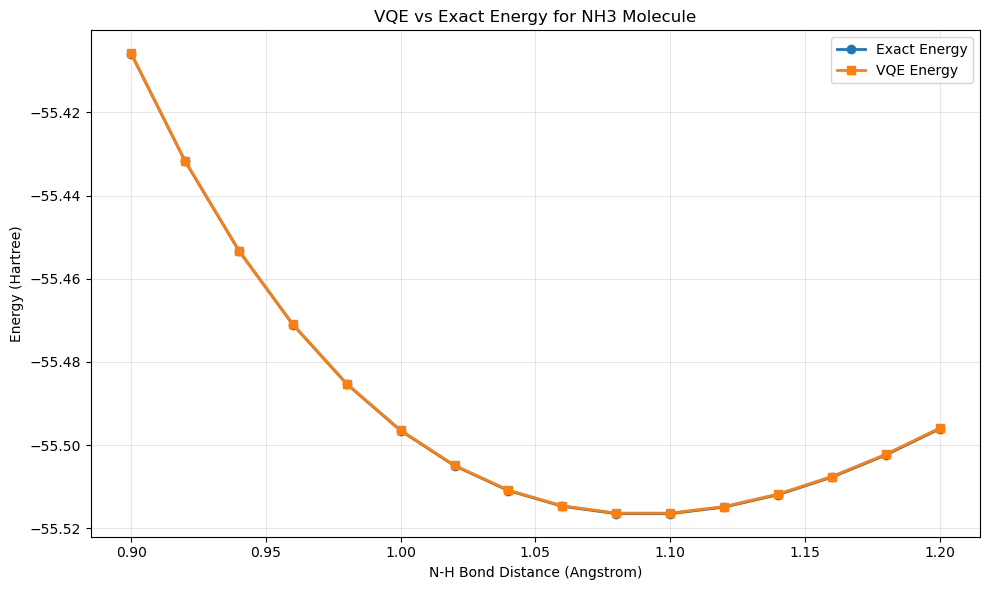

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(distances, exact_energies, 'o-', label="Exact Energy", linewidth=2)
plt.plot(distances, vqe_energies, 's-', label="VQE Energy", linewidth=2)
plt.xlabel("N-H Bond Distance (Angstrom)")
plt.ylabel("Energy (Hartree)")
plt.title("VQE vs Exact Energy for NH3 Molecule")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# compare different ansatz

In [10]:
ANSATZ = 'EfficientSU2'  # Change ansatz to EfficientSU2
exact_energies, vqe_energies, results = run_vqe_calculations(
    distances=distances,
    ansatz=ANSATZ,
    filename=f'vqe_{ANSATZ}_{OPTIMIZER}.pkl',
)

Loading results from: results/vqe_EfficientSU2_SLSQP.pkl
Loaded results for 16 bond length configurations
Computation date: 2025-07-29T19:14:48.286245
Molecule: NH3
Ansatz: EfficientSU2
Optimizer: SLSQP
Found existing results for 16 bond lengths.


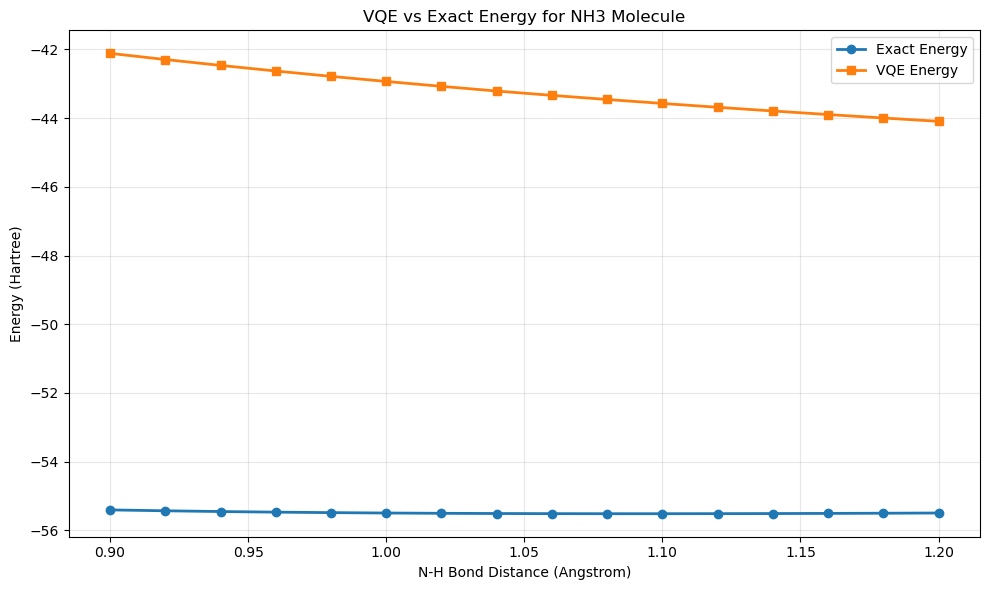

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(distances, exact_energies, 'o-', label="Exact Energy", linewidth=2)
plt.plot(distances, vqe_energies, 's-', label="VQE Energy", linewidth=2)
plt.xlabel("N-H Bond Distance (Angstrom)")
plt.ylabel("Energy (Hartree)")
plt.title("VQE vs Exact Energy for NH3 Molecule")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
ANSATZ = 'TwoLocal' 

exact_energies, vqe_energies, results = run_vqe_calculations(
    distances=distances,
    ansatz=ANSATZ,
    filename=f'vqe_{ANSATZ}_{OPTIMIZER}.pkl',
)

Loading results from: results/vqe_TwoLocal_SLSQP.pkl
No previous results found, proceeding with new calculations.
Starting VQE calculations...
   Distances: 16 points from 0.90 to 1.20 Å
   Ansatz: TwoLocal
   Optimizer: SLSQP (maxiter=10)
   Save results: True
   Running parallel computations...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:   12.2s remaining:   52.8s
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:   12.3s remaining:   27.2s
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:   12.2s remaining:   52.8s
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:   12.3s remaining:   27.2s
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:   12.5s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:   12.5s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:   12.8s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:   12.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:   12.8s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:   12.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:   13.1s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  13 


Calculation Statistics:
   Mean absolute error: 0.080537 Hartree
   Max absolute error: 0.108606 Hartree
   Min absolute error: 0.056984 Hartree

Files saved:
   - results/vqe_TwoLocal_SLSQP.pkl (complete results)
   - results/vqe_TwoLocal_SLSQP.json (human-readable)

VQE calculations completed successfully!


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   13.3s finished


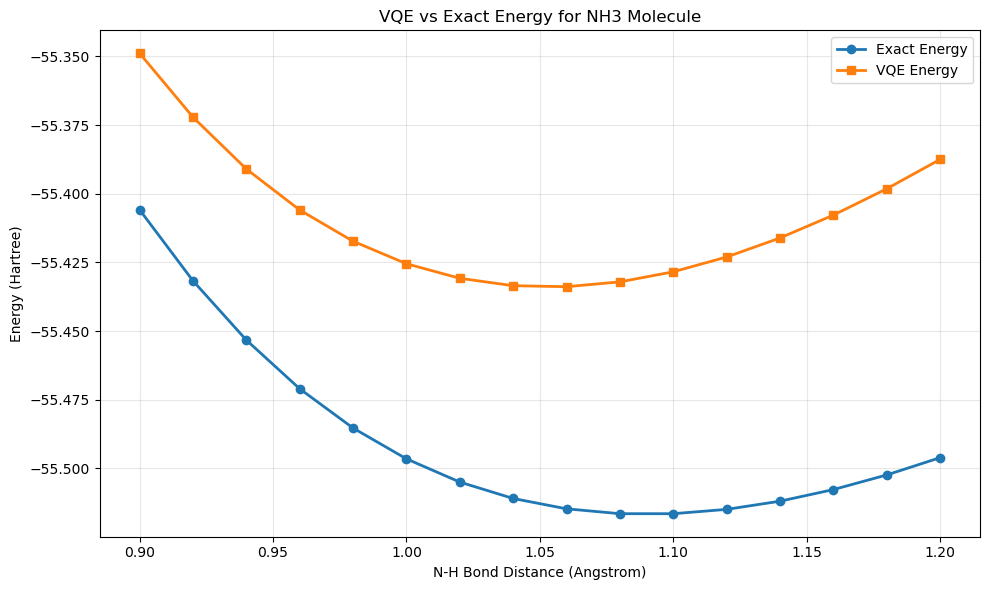

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(distances, exact_energies, 'o-', label="Exact Energy", linewidth=2)
plt.plot(distances, vqe_energies, 's-', label="VQE Energy", linewidth=2)
plt.xlabel("N-H Bond Distance (Angstrom)")
plt.ylabel("Energy (Hartree)")
plt.title("VQE vs Exact Energy for NH3 Molecule")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# different optimizers

In [15]:
ANSATZ = 'TwoLocal'
optimizers = ['SLSQP', 'SPSA', 'L_BFGS_B']

optimizer_results = {}
for opt_name in optimizers:
    print(f"\nRunning VQE with optimizer: {opt_name}")
    filename = f'vqe_{ANSATZ}_{opt_name}.pkl'
    exact_energies, vqe_energies, results = run_vqe_calculations(
        distances=distances,
        ansatz=ANSATZ,
        optimizer=opt_name,
        filename=filename,
    )
    
    optimizer_results[opt_name] = {
        'exact_energies': exact_energies,
        'vqe_energies': vqe_energies,
        'errors': np.abs(exact_energies - vqe_energies),
        'times': results['times'],
        'mol_props': results['molecular_properties'],
        'vqe_details': results['vqe_details']
    }


Running VQE with optimizer: SLSQP
Loading results from: results/vqe_TwoLocal_SLSQP.pkl
Loaded results for 16 bond length configurations
Computation date: 2025-07-29T22:34:46.455145
Molecule: NH3
Ansatz: TwoLocal
Optimizer: SLSQP
Found existing results for 16 bond lengths.

Running VQE with optimizer: SPSA
Loading results from: results/vqe_TwoLocal_SPSA.pkl
No previous results found, proceeding with new calculations.
Starting VQE calculations...
   Distances: 16 points from 0.90 to 1.20 Å
   Ansatz: TwoLocal
   Optimizer: SPSA (maxiter=10)
   Save results: True
   Running parallel computations...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:   10.8s remaining:   46.8s
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:   10.9s remaining:   23.9s
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:   11.0s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:   10.8s remaining:   46.8s
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:   10.9s remaining:   23.9s
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:   11.0s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:   11.2s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:   11.3s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:   11.2s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:   11.3s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:   11.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  16 


Calculation Statistics:
   Mean absolute error: 4.128781 Hartree
   Max absolute error: 6.217301 Hartree
   Min absolute error: 2.892466 Hartree

Files saved:
   - results/vqe_TwoLocal_SPSA.pkl (complete results)
   - results/vqe_TwoLocal_SPSA.json (human-readable)

VQE calculations completed successfully!

Running VQE with optimizer: L_BFGS_B
Loading results from: results/vqe_TwoLocal_L_BFGS_B.pkl
No previous results found, proceeding with new calculations.
Starting VQE calculations...
   Distances: 16 points from 0.90 to 1.20 Å
   Ansatz: TwoLocal
   Optimizer: L_BFGS_B (maxiter=10)
   Save results: True
   Running parallel computations...


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:    9.7s remaining:   42.0s
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:   10.0s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:   10.1s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:   10.0s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:   10.1s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:   10.3s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:   10.3s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:   10.5s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:   10.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:   10.5s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:   10.6s remaining:    2.4s



Calculation Statistics:
   Mean absolute error: 0.080537 Hartree
   Max absolute error: 0.108606 Hartree
   Min absolute error: 0.056984 Hartree

Files saved:
   - results/vqe_TwoLocal_L_BFGS_B.pkl (complete results)
   - results/vqe_TwoLocal_L_BFGS_B.json (human-readable)

VQE calculations completed successfully!


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   10.9s finished
